In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pandas as pd
import keras

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
# from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/MyDrive/Data/train'
val_path = '/content/drive/MyDrive/Data/valid'
test_path = '/content/drive/MyDrive/Data/test'

input_shape = (224,224,3)
num_classes = 4
batch_size = 16
img_height = 224
img_width = 224


#loads in training data
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#loads in validation data
val_ds = tf.keras.utils.image_dataset_from_directory(
  val_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#loads in testing data
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle=False) #shuffles by default which is not recommended for the testing dataset


Found 613 files belonging to 4 classes.
Found 72 files belonging to 4 classes.
Found 315 files belonging to 4 classes.


In [ ]:
train_labels = train_ds.class_names
print('Train Labels',train_labels)
val_labels = val_ds.class_names
print('Validation Labels',val_labels)
test_labels = test_ds.class_names
print('Test Labels',test_labels)

Train Labels ['Adenocarcinoma', 'Large Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']
Validation Labels ['Adenocarcinoma', 'Large Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']
Test Labels ['Adenocarcinoma', 'Large Cell Carcinoma', 'Normal', 'Squamous Cell Carcinoma']


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import activations

# Data augmentation
data_augmentation = Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Load ResNet50 model
resnet50_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape,
    pooling='avg'  # Global average pooling
)

# Unfreeze some layers in the ResNet50 model
for layer in resnet50_model.layers[-20:]:
    layer.trainable = True

# Build model
model = Sequential([
    data_augmentation,
    resnet50_model,
    BatchNormalization(),
    Flatten(),
    Dense(1024, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(num_classes, activation='softmax')  # Use 'softmax' at output layer for more than 2 outputs
])

# Lower the learning rate for Adam
adam = Adam(learning_rate=1e-4)

# Compile the model with the specified learning rate
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cancer_model.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Fit the model with data augmentation, specifying one-hot encoding for labels
history = model.fit(
    train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))),  # Convert labels to one-hot
    validation_data=val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))),  # Convert labels to one-hot
    epochs=100,
    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

# Summarize the model
model.summary()

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 133s 2s/step - accuracy: 0.3576 - loss: 26.8830 - val_accuracy: 0.4861 - val_loss: 26.2760 - learning_rate: 1.0000e-04
Epoch 2/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 73s 411ms/step - accuracy: 0.5452 - loss: 26.0430 - val_accuracy: 0.5000 - val_loss: 25.6596 - learning_rate: 1.0000e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 432ms/step - accuracy: 0.6271 - loss: 25.3065 - val_accuracy: 0.5139 - val_loss: 25.3930 - learning_rate: 1.0000e-04
Epoch 4/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 517ms/step - accuracy: 0.6666 - loss: 24.7497 - val_accuracy: 0.4861 - val_loss: 24.6159 - learning_rate: 1.0000e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 469ms/step - accuracy: 0.6293 - loss: 24.2286 - val_accuracy: 0.5139 - val_loss: 23.9679 - learning_rate: 1.0000e-04
Epoch 6/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 424ms/step - accuracy: 0.6724 - loss: 23.5944 - val_accuracy: 0.5417 - val_loss: 23.5956 - learning_rate: 1.0000e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 2048)                │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,036,430 (301.50 MB)

 Trainable params: 26,326,404 (100.43 MB)

 Non-trainable params: 57,216 (223.50 KB)

 Optimizer params: 52,652,810 (200.85 MB)

In [ ]:
# Evaluate the model with data augmentation, specifying one-hot encoding for labels
test_loss, test_accuracy = model.evaluate(test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))))
train_loss, train_accuracy = model.evaluate(train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=num_classes))))
print('Train accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

39/39 [==============================] - 4s 89ms/step - loss: 0.5588 - accuracy: 0.9951
Train accuracy: 0.995106041431427
Test accuracy: 0.9555555582046509


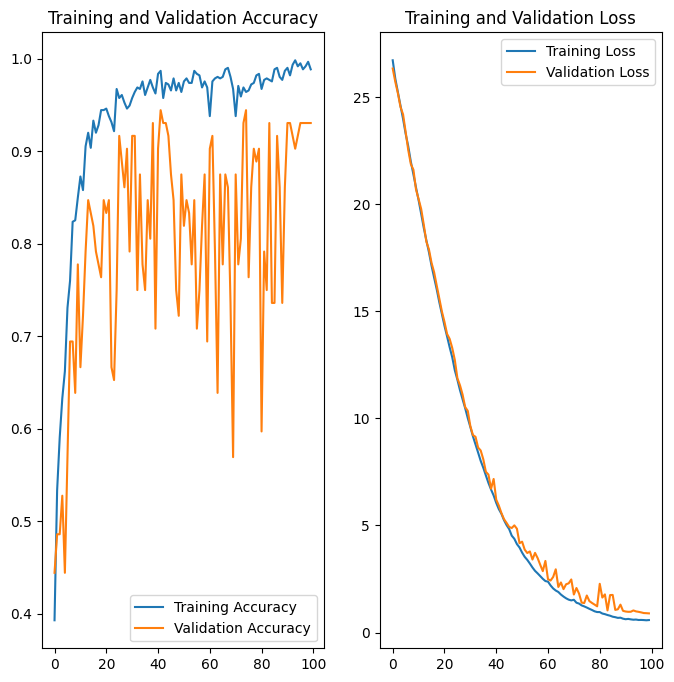

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = len(acc)
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
squamous_url = "/content/drive/MyDrive/Data/valid/Squamous Cell Carcinoma/000119 (5).png"
squamous_path = tf.keras.utils.get_file('000119 (5)', origin=squamous_url)

img = tf.keras.utils.load_img(
    squamous_url, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch


predictions = model.predict(val_ds)
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(val_labels[np.argmax(score)], 100 * np.max(score))
)



ValueError: unknown url type: '/content/drive/MyDrive/Data/valid/Squamous Cell Carcinoma/000119 (5).png'

In [ ]:
# Load the image directly using load_img since it's a local file
img = tf.keras.utils.load_img(
    "/content/drive/MyDrive/Data/valid/Normal/5.png", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Make predictions
predictions = model.predict(img_array)  # Predict on the single image
score = tf.nn.softmax(predictions[0])
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(val_labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 2s 2s/step
This image most likely belongs to Normal with a 47.52 percent confidence.


In [ ]:
# Get predictions
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = np.concatenate([y for x, y in test_ds], axis=0)

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=test_ds.class_names))

# Print confusion matrix
print(confusion_matrix(true_classes, predicted_classes))

20/20 [==============================] - 3s 94ms/step
                         precision    recall  f1-score   support

         Adenocarcinoma       0.97      0.93      0.94       120
   Large Cell Carcinoma       0.89      1.00      0.94        51
                 Normal       1.00      0.98      0.99        54
Squamous Cell Carcinoma       0.96      0.96      0.96        90

               accuracy                           0.96       315
              macro avg       0.95      0.97      0.96       315
           weighted avg       0.96      0.96      0.96       315

[[111   5   0   4]
 [  0  51   0   0]
 [  1   0  53   0]
 [  3   1   0  86]]


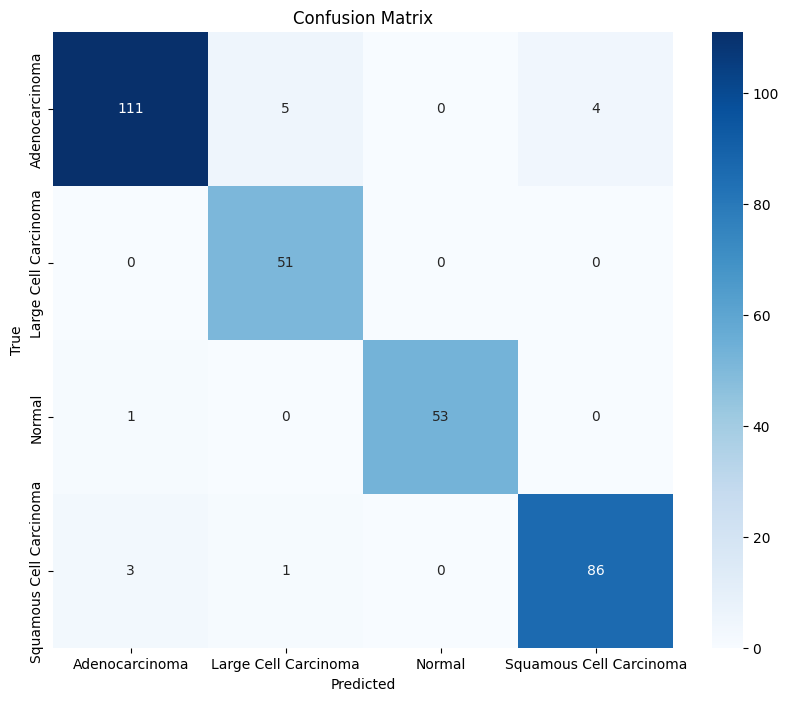

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_labels, yticklabels=test_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('cancer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
